In [1]:
from global_vars import *
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [7]:
pa = IMAGE_EXAMPLE
pa2 = SUBIMAGE_EXAMPLE
img = cv.imread(pa, cv.IMREAD_GRAYSCALE)


# # Threshold to binary
_, binary = cv.threshold(img, 127, 1, cv.THRESH_BINARY_INV)  
skeleton = skeletonize(1 - binary)

In [9]:
pa2 = SUBIMAGE_EXAMPLE
img2 = cv.imread(pa2, cv.IMREAD_GRAYSCALE)

# Threshold to binary
_, binary2 = cv.threshold(img2, 127, 1, cv.THRESH_BINARY_INV)  
skeleton2 = skeletonize(1 - binary2)

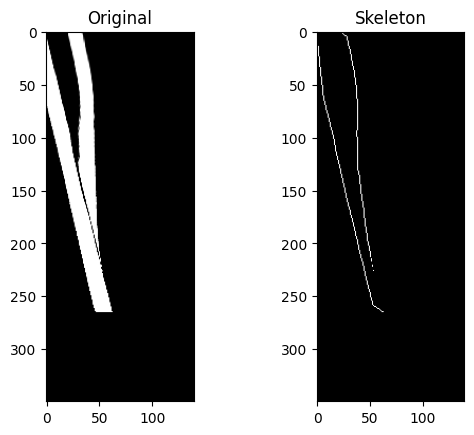

In [10]:
plt.subplot(1, 2, 1)
plt.title("Original")
imgBOTH = img + img2
plt.imshow(cv.cvtColor(imgBOTH, cv.COLOR_BGR2RGB))

# plt.subplot(1, 3, 2)
# plt.title("Binary")
# plt.imshow(binary, cmap='gray')

skeleton = skeleton + skeleton2
plt.subplot(1, 2, 2)
plt.title("Skeleton")
plt.imshow(skeleton, cmap='gray')

plt.show()

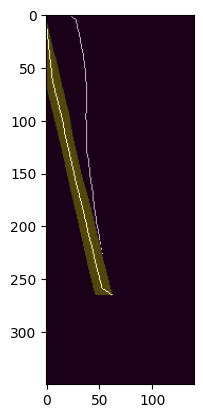

In [11]:
plt.imshow(img)

# Скелет: белый цвет + alpha, показываем только где skeleton == 1
plt.imshow(skeleton, cmap='hot', alpha=0.7)  # или cmap='gray'

plt.show()

In [13]:
both = img + img2
_, binary2Both = cv.threshold(both, 127, 1, cv.THRESH_BINARY_INV)  
skeletonBoth = skeletonize(1 - binary2Both)

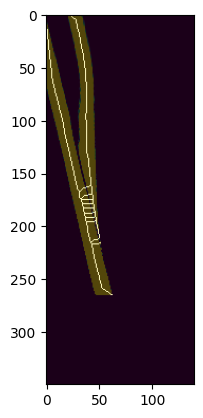

In [14]:
plt.imshow(both)

# Скелет: белый цвет + alpha, показываем только где skeleton == 1
plt.imshow(skeletonBoth, cmap='hot', alpha=0.7)  # или cmap='gray'

plt.show()

In [15]:
# saving mask
import imageio
def save_mask(mask : np.ndarray, to = 'rail_mask.png'):
    mask_to_save = (mask * 255).astype(np.uint8)
    imageio.imwrite(to, mask_to_save)


In [16]:
import numpy as np
import skfmm
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

In [ ]:
# mask = np.round((np.array(img) + np.array(img2)) / 255)
# save_mask(mask)

In [ ]:
if 1 in mask:
    print(123)
print(mask.shape)


123
(350, 140)


In [ ]:
start1 = (0, 26)
end = (266, 53)
# start = (266, 53)
# end = (0, 26)

In [ ]:
def get_trajectory_from_mask(start, end, mask, alpha, boost_value=0, vis=False):
    dt = distance_transform_edt(mask)

    # Чтобы скорость была выше по центру:
    # F = dt.copy()
    corridor = np.zeros_like(mask)
    cv.line(corridor, (start[1], start[0]), (end[1], end[0]), 1, thickness=5)

    # Добавляем вес
    F = dt.copy()
    F += corridor * boost_value  # boost_value > 0
    F[~mask.astype(bool)] = 1e-10  # почти нулевая скорость вне рельса

    # === 4. Инициализация Fast Marching ===
    # Ставим стартовую точку отрицательной
    phi = np.ones_like(mask, dtype=float)
    phi[start] = -20  # внутри — фронт

    # === 5. Вычисляем карту времени ===
    T = skfmm.travel_time(phi, speed=F)

    # === 6. Построим путь от End обратно по градиенту ===
    path = [end]
    pt = np.array(end, dtype=float)

    gy, gx = np.gradient(T)

    for _ in range(20000):
        y, x = int(round(pt[0])), int(round(pt[1]))

        # Если вылезли за границы
        if y < 1 or y >= T.shape[0]-1 or x < 1 or x >= T.shape[1]-1:
            break

        # Градиент
        grad = np.array([gy[y, x], gx[y, x]])
        norm = np.linalg.norm(grad)
        if norm < 1e-5:
            break
        grad /= norm

        # Шаг против градиента (идём к старту)
        step = -grad * alpha
        pt += step

        path.append(pt.copy())

        # Если близко к старту — стоп
        if np.linalg.norm(pt - np.array(start)) < 1.0:
            break

    path = np.array(path)

    if vis:
        plt.figure(figsize=(10, 10))
        plt.imshow(mask, cmap='gray')
        plt.plot(path[:,1], path[:,0], 'r-', lw=2)
        plt.plot(start[1], start[0], 'go')  # Start
        plt.plot(end[1], end[0], 'bo')      # End
        plt.title("Траектория по Fast Marching")
        plt.show()
    return path

In [ ]:
import cv2
import numpy as np

def import_image_as_mask(path):
    mask_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    mask_joined = (mask_img > 128).astype(np.uint8)

    print(mask_joined.shape)
    print(np.unique(mask_joined)) 
    return mask_img


In [ ]:
def vis(p1, p2, mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    plt.plot(p1[:,1], p1[:,0], 'r-', lw=2)
    plt.plot(p2[:,1], p2[:,0], 'g-', lw=2)
    # plt.plot(start[1], start[0], 'go')  # Start
    # plt.plot(end[1], end[0], 'bo')      # End
    plt.title("Траектория по Fast Marching")
    plt.show()

In [ ]:
end = (169, 39)
start1 = (0, 26)
start = (41, 0)
end1 = (266, 53)

(350, 140)
[0 1]
(350, 140)
[0 1]


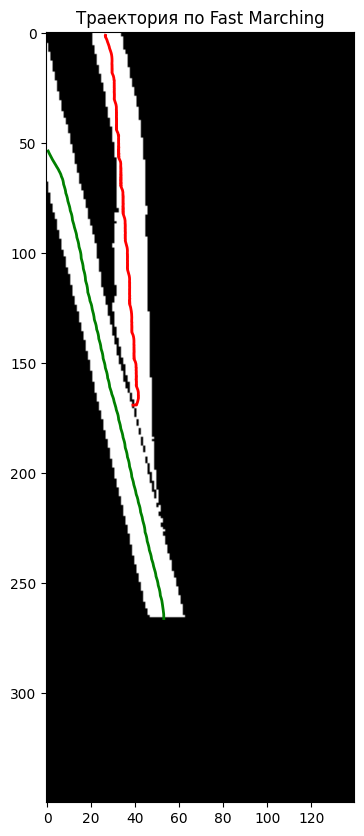

In [ ]:
mask_1 = import_image_as_mask(SUBIMAGE_EXAMPLE)
mask_2 = import_image_as_mask(IMAGE_EXAMPLE)
p1 = get_trajectory_from_mask(start1, end, mask_1, 0.2, 2)
p2 = get_trajectory_from_mask(start, end1, mask, 0.2, 2)
vis(p1, p2, mask)

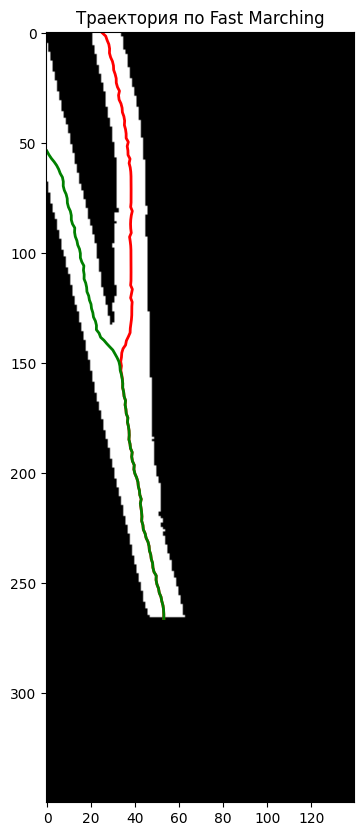

In [ ]:
p1 = get_trajectory_from_mask(start1, end1, mask_joined, 2)
p2 = get_trajectory_from_mask(start2, end1, mask_joined, 2)
vis(p1, p2, mask_joined)